We shall now build and train a Convolutional Neural Network on the augmented Oxford IIIT Pet Dataset.

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn

# Data loading

We shall use the Dataset class to build a custom dataset class inheriting from it.

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = read_image(img_path)
        class_label = self.img_annotations.iloc[idx,2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)
        return image, class_label

Let's define the transforms, read_image already reads the images as tensors so we don't need to use ToTensor, we shall only resize the images to 200 pixels. We use the Lambda transform to define a function to apply one-hot encoding on the class ids (of which there are 37, the -1 in the scatter_ below is coz the indices start from 0).

In [8]:
resize = T.Resize(200)
label_transform = T.Lambda(lambda y: torch.zeros(37, dtype=torch.float).scatter_(dim=0,index=torch.tensor(y-1),value=1))

In [9]:
train_r1 = PetDataset('annotations_aug/annotations_train_r1.csv','img_augmented_processed/', transform = resize, target_transform = label_transform)
train_r2 = PetDataset('annotations_aug/annotations_train_r2.csv','img_augmented_processed/', transform = resize, target_transform = label_transform)
train_r3 = PetDataset('annotations_aug/annotations_train_r3.csv','img_augmented_processed/', transform = resize, target_transform = label_transform)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = resize, target_transform = label_transform)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = resize, target_transform = label_transform)

In [10]:
train_r1_loader = DataLoader(train_r1,batch_size=64,shuffle=True)
train_r2_loader = DataLoader(train_r2,batch_size=64,shuffle=True)
train_r3_loader = DataLoader(train_r3,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=64,shuffle=True)
test_loader = DataLoader(test,batch_size=64,shuffle=True)

We can call the first batch in the following way:

shape of training batch (images): torch.Size([64, 3, 200, 200])


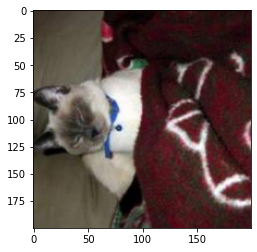

In [11]:
train_b1_img, train_b1_label = next(iter(train_r1_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model

In [7]:
class PetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(
                                    nn.Linear(1168, 37)) 
                            
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.dense1(out)
        out = nn.functional.log_softmax(out)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model = PetCNN()
loss_function = nn.NLLLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

print(model)
        

PetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (dense1): Sequential(
    (0): Linear(in_features=1168, out_features=37, bias=True)
  )
)
